In [1]:
from __future__ import division, print_function

import lib.xmlreader as xml
import lib.utils as ut
import numpy as np

import gensim.models.word2vec
import itertools
from collections import Counter
from nltk.tokenize import word_tokenize

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import collections
import numpy as np
import matplotlib.pyplot as plt
import operator
import os
%matplotlib inline

C:\Users\dapal\AppData\Local\conda\conda\envs\SI\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train_docs= xml.readXML("../database/TASS/TASS2018/task1-Training.xml")

In [3]:
test_docs= xml.readXML("../database/TASS/TASS2018/task1-Development.xml")
# train_docs = train_docs[0:700]
# test_docs = train_docs[-300:]

In [4]:
corpus = []
for doc in train_docs + test_docs:
    corpus.append(doc.content)

In [5]:
train_labels = []
for doc in train_docs:
    train_labels.append(doc.polarity)
    
test_labels = []
for doc in test_docs:
    test_labels.append(doc.polarity)

In [6]:
def gensim_load_vec(path="../database/embeddings/SBW-vectors-300-min5.bin"):
    #use gensim_emb.wv.index2word if used this way to load vectors
    #gensim_emb = gensim.models.word2vec.Word2Vec.load(path)
    gensim_emb =  gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
    vocab = gensim_emb.index2word
    vec = gensim_emb.syn0
    shape = gensim_emb.syn0.shape
    return gensim_emb, vec, shape, vocab

In [7]:
gensim_emb, vec, shape, vocab = gensim_load_vec()

C:\Users\dapal\AppData\Local\conda\conda\envs\SI\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  
C:\Users\dapal\AppData\Local\conda\conda\envs\SI\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


## Estimate Vocabulary Size

In [8]:
counter = CountVectorizer(tokenizer=ut.tokenizer, min_df=1)

In [9]:
X = counter.fit_transform(corpus)
print(X.shape)

(674, 3069)


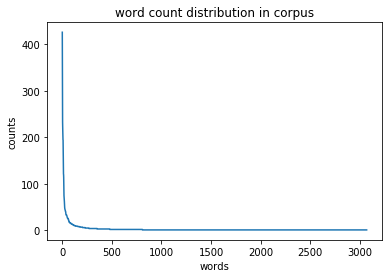

In [10]:
counts = np.sum(X, axis=0).tolist()
counts = sorted(counts[0], reverse=True)
plt.plot(np.arange(len(counts)), counts)
plt.title("word count distribution in corpus")
plt.ylabel("counts")
plt.xlabel("words")
acc = []

## Compute Baseline Embedding (BoW)

<a href="https://www.codecogs.com/eqnedit.php?latex=v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;v_w" target="_blank"><img src="https://latex.codecogs.com/gif.latex?v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;v_w" title="v_s = \frac{1}{\left \| S \right \|} \sum_{w \in S} v_w" /></a>

In [11]:
# VOCAB_SIZE = 3000
VOCAB_SIZE = X.shape[1]
# counter = CountVectorizer(strip_accents="unicode", max_features=VOCAB_SIZE)
# counter = CountVectorizer(max_features=VOCAB_SIZE, tokenizer=ut.tokenizer)

caption_texts = corpus
Xc = counter.fit_transform(caption_texts).todense().astype("float")
print(Xc.shape)

(674, 3069)


In [12]:
sent_lens = np.sum(Xc, axis=1).astype("float")
sent_lens[sent_lens == 0] = 1e-14
print(sent_lens.shape)

(674, 1)


In [13]:
E = np.zeros((VOCAB_SIZE, 300))
for word in counter.vocabulary_.keys():
    try:
        i = counter.vocabulary_[word]
        E[i] = gensim_emb[word]
    except KeyError:
        pass
print(E.shape)

(3069, 300)


In [14]:
Xb = np.divide(np.dot(Xc, E), sent_lens)
print(Xb.shape)

(674, 300)


In [15]:
Xtrain, Xtest = Xb[0:len(train_docs)], Xb[len(train_docs):]
ytrain, ytest = np.array(train_labels), np.array(test_labels)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(473, 300) (473,) (201, 300) (201,)


In [40]:
def cross_val(Xtrain, ytrain, clf):
    best_clf = None
    best_score = 0.0
    num_folds = 0
    cv_scores = []
    kfold = KFold(n_splits=10)
    for train, val in kfold.split(Xtrain):
        Xctrain, Xctest, yctrain, yctest = Xtrain[train], Xtrain[val], ytrain[train], ytrain[val]
        clf.fit(np.concatenate((Xctrain, Xctest), axis=0), np.concatenate((yctrain, yctest), axis=0))
        # clf.fit(Xctrain, yctrain)
        score = clf.score(Xctest, yctest)
        if score > best_score:
            best_score = score
            best_clf = clf
        print("fold {:d}, score: {:.3f}".format(num_folds, score))
        cv_scores.append(score)
        num_folds += 1
    return best_clf, cv_scores

def test_eval(Xtest, ytest, clf):
    print("===")
    print("Test set results")
    ytest_ = clf.predict(Xtest)
    accuracy = accuracy_score(ytest, ytest_)
    acc.append(accuracy)
    print("Accuracy: {:.3f}".format(accuracy))
    print("---")
    print("Confusion Matrix")
    cm = confusion_matrix(ytest, ytest_)
    print(cm)
    print("---")
    print("Classification Report")
    cr = classification_report(ytest, ytest_)
    print(cr)

In [17]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
best_clf, scores_nb = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.646
fold 1, score: 0.604
fold 2, score: 0.583
fold 3, score: 0.702
fold 4, score: 0.787
fold 5, score: 0.809
fold 6, score: 0.638
fold 7, score: 0.681
fold 8, score: 0.617
fold 9, score: 0.617
===
Test set results
Accuracy: 0.597
---
Confusion Matrix
[[82 24]
 [57 38]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       106
           1       0.61      0.40      0.48        95

   micro avg       0.60      0.60      0.60       201
   macro avg       0.60      0.59      0.58       201
weighted avg       0.60      0.60      0.58       201



In [18]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=0.8)
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.812
fold 1, score: 0.833
fold 2, score: 0.792
fold 3, score: 0.915
fold 4, score: 0.936
fold 5, score: 0.872
fold 6, score: 0.787
fold 7, score: 0.787
fold 8, score: 0.809
fold 9, score: 0.830
===
Test set results
Accuracy: 0.706
---
Confusion Matrix
[[93 13]
 [46 49]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       106
           1       0.79      0.52      0.62        95

   micro avg       0.71      0.71      0.71       201
   macro avg       0.73      0.70      0.69       201
weighted avg       0.73      0.71      0.70       201



## Smooth Inverse Frequency (SIF) Embedding

<a href="https://www.codecogs.com/eqnedit.php?latex=v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;\frac{\alpha}{\alpha&space;&plus;&space;p_w}&space;v_w" target="_blank"><img src="https://latex.codecogs.com/gif.latex?v_s&space;=&space;\frac{1}{\left&space;\|&space;S&space;\right&space;\|}&space;\sum_{w&space;\in&space;S}&space;\frac{\alpha}{\alpha&space;&plus;&space;p_w}&space;v_w" title="v_s = \frac{1}{\left \| S \right \|} \sum_{w \in S} \frac{\alpha}{\alpha + p_w} v_w" /></a>

In [19]:
# from paper
ALPHA = 1e-3

In [20]:
# # compute word probabilities from corpus
freqs = np.sum(Xc, axis=0).astype("float")
probs = freqs / np.sum(freqs)

In [21]:
# compute multiplier ALPHA / (ALPHA + probs)
coeff = ALPHA / (ALPHA + probs)

In [22]:
# compute weighted counts
Xw = np.multiply(Xc, coeff)

In [23]:
# convert to SIF embeddings
Xs = np.divide(np.dot(Xw, E), sent_lens)

print(Xc.shape, coeff.shape, Xs.shape, E.shape)

(674, 3069) (1, 3069) (674, 300) (3069, 300)


In [24]:
# compute 1st principal component
svd = TruncatedSVD(n_components=1, n_iter=20, random_state=0)
svd.fit(Xs)
pc = svd.components_
print(pc.shape, svd.explained_variance_ratio_)

(1, 300) [0.0856046]


In [25]:
# remove it from the weighted counts
Xr = Xs - Xs.dot(pc.T).dot(pc)
print(Xr.shape)

(674, 300)


In [26]:
Xtrain, Xtest = Xr[0:len(train_docs)], Xr[-len(test_docs):]
ytrain, ytest = np.array(train_labels), np.array(test_labels)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(473, 300) (473,) (201, 300) (201,)


In [27]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
best_clf, scores_nb = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.708
fold 1, score: 0.667
fold 2, score: 0.646
fold 3, score: 0.787
fold 4, score: 0.766
fold 5, score: 0.809
fold 6, score: 0.745
fold 7, score: 0.660
fold 8, score: 0.681
fold 9, score: 0.681
===
Test set results
Accuracy: 0.622
---
Confusion Matrix
[[89 17]
 [59 36]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.84      0.70       106
           1       0.68      0.38      0.49        95

   micro avg       0.62      0.62      0.62       201
   macro avg       0.64      0.61      0.59       201
weighted avg       0.64      0.62      0.60       201



In [48]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=0.5, gamma='scale')
best_clf, scores_svc = cross_val(Xtrain, ytrain, clf)
test_eval(Xtest, ytest, best_clf)

fold 0, score: 0.750
fold 1, score: 0.750
fold 2, score: 0.792
fold 3, score: 0.851
fold 4, score: 0.830
fold 5, score: 0.809
fold 6, score: 0.766
fold 7, score: 0.702
fold 8, score: 0.766
fold 9, score: 0.745
===
Test set results
Accuracy: 0.697
---
Confusion Matrix
[[98  8]
 [53 42]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       106
           1       0.84      0.44      0.58        95

   micro avg       0.70      0.70      0.70       201
   macro avg       0.74      0.68      0.67       201
weighted avg       0.74      0.70      0.68       201



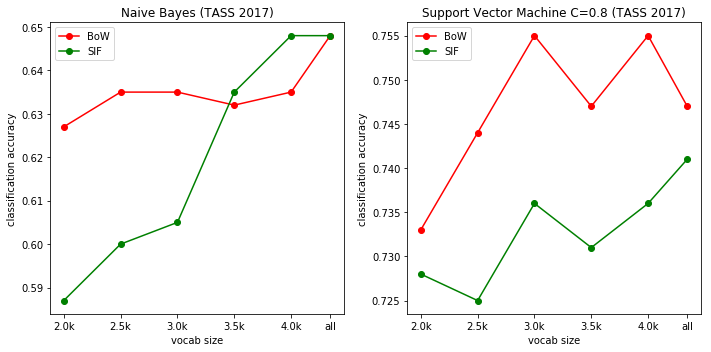

In [29]:
xlabels = ["2.0k", "2.5k", "3.0k", "3.5k", "4.0k", "all"]
# xs = [10000, 20000, 30000, 40000, 50000, 64170, 64450]
# we have changed the actual numbers to evenly space the points
xs = [2000, 2500, 3000, 3500, 4000, 4344]

ylabels = ["BoW/NB", "BoW/SVM", "SIF/NB", "SIF/SVM"]
ys = np.array(
        [[0.627, 0.635, 0.635, 0.632, 0.635, 0.648],
         [0.733, 0.744, 0.755, 0.747, 0.755, 0.747],
         [0.587, 0.600, 0.605, 0.635, 0.648, 0.648],
         [0.728, 0.725, 0.736, 0.731, 0.736, 0.741]])
ids_nb = [i for i, y in enumerate(ylabels) if y.endswith("/NB")]
labels_nb = [y.split("/")[0] for y in ylabels if y.endswith("/NB")]
ids_svm = [i for i, y in enumerate(ylabels) if y.endswith("/SVM")]
labels_svm = [y.split("/")[0] for y in ylabels if y.endswith("/SVM")]
colors = ["r", "g", "b"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
curr_row = 0
for row in ids_nb:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_nb[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Naive Bayes (TASS 2017)")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.subplot(122)
curr_row = 0
for row in ids_svm:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_svm[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Support Vector Machine C=0.8 (TASS 2017)")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

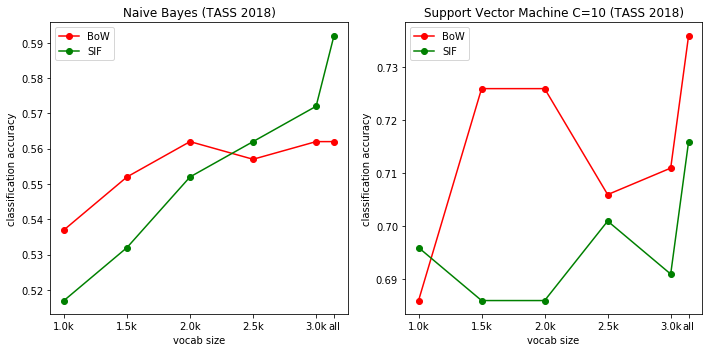

In [30]:
xlabels = ["1.0k", "1.5k", "2.0k", "2.5k", "3.0k", "all"]
# xs = [10000, 20000, 30000, 40000, 50000, 64170, 64450]
# we have changed the actual numbers to evenly space the points
xs = [1000, 1500, 2000, 2500, 3000, 3142]

ylabels = ["BoW/NB", "BoW/SVM", "SIF/NB", "SIF/SVM"]
ys = np.array(
        [[0.537, 0.552, 0.562, 0.557, 0.562, 0.562],
         [0.686, 0.726, 0.726, 0.706, 0.711, 0.736],
         [0.517, 0.532, 0.552, 0.562, 0.572, 0.592],
         [0.696, 0.686, 0.686, 0.701, 0.691, 0.716]])
ids_nb = [i for i, y in enumerate(ylabels) if y.endswith("/NB")]
labels_nb = [y.split("/")[0] for y in ylabels if y.endswith("/NB")]
ids_svm = [i for i, y in enumerate(ylabels) if y.endswith("/SVM")]
labels_svm = [y.split("/")[0] for y in ylabels if y.endswith("/SVM")]
colors = ["r", "g", "b"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
curr_row = 0
for row in ids_nb:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_nb[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Naive Bayes (TASS 2018)")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.subplot(122)
curr_row = 0
for row in ids_svm:
    plt.plot(xs, ys[row, :], marker="o", 
             color=colors[curr_row], label=labels_svm[curr_row])
    curr_row += 1
plt.xticks(xs, xlabels)
plt.title("Support Vector Machine C=10 (TASS 2018)")
plt.ylabel("classification accuracy")
plt.xlabel("vocab size")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [32]:
# Network building
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    # Inputs
    net = tflearn.input_data([None, 45])

    # Hidden layer(s)
    net = tflearn.fully_connected(net, 300, activation='ReLU')
    #net = tflearn.dropout(net, keep_prob=0.2)
    net = tflearn.fully_connected(net, 150, activation='ReLU')
    net = tflearn.fully_connected(net, 50, activation='ReLU')
    net = tflearn.fully_connected(net, 10, activation='ReLU')

    # Output layer
    net = tflearn.fully_connected(net, 2, activation='sigmoid')
    net = tflearn.regression(net, optimizer='sgd', 
                             learning_rate=0.5, 
                             loss='categorical_crossentropy')
    
    model = tflearn.DNN(net)
    return model

In [33]:
model = build_model()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [34]:
sequences = []
for tweet in corpus:
    sentence = []
    for word in ut.tokenizer(tweet):
        try:
            i = counter.vocabulary_[word]
            sentence.append(i)
        except KeyError:
            pass
        
    sequences.append(sentence)

In [35]:
from keras.preprocessing.sequence import pad_sequences
x_train_seq = pad_sequences(sequences[:len(ytrain)], maxlen=45)
x_test_seq  = pad_sequences(sequences[len(ytrain):], maxlen=45)
print('Shape of data train tensor:', x_train_seq.shape)
print('Shape of data val  tensor:', x_test_seq.shape)

Using TensorFlow backend.


Shape of data train tensor: (473, 45)
Shape of data val  tensor: (201, 45)


In [36]:
# model.fit(x_train_seq, ytrain, validation_set=0.2, show_metric=True, batch_size=64, n_epoch=150)
model.fit(x_train_seq, to_categorical(ytrain, 2), validation_set=0.2, show_metric=True, batch_size=64, n_epoch=150)

Training Step: 899  | total loss: 0.69315 | time: 0.016s
| SGD | epoch: 150 | loss: 0.69315 - acc: 0.5127 -- iter: 320/378
Training Step: 900  | total loss: 0.69315 | time: 1.032s
| SGD | epoch: 150 | loss: 0.69315 - acc: 0.5114 | val_loss: 0.69315 - val_acc: 0.4737 -- iter: 378/378
--


In [37]:
from numpy import argmax
def test_eval(Xtest, ytest, clf):
    print("===")
    print("Test set results")
    ytest_ = argmax(clf.predict(Xtest), axis=1)
    accuracy = accuracy_score(ytest, ytest_)
    acc.append(accuracy)
    print("Accuracy: {:.3f}".format(accuracy))
    print("---")
    print("Confusion Matrix")
    cm = confusion_matrix(ytest, ytest_)
    print(cm)
    print("---")
    print("Classification Report")
    cr = classification_report(ytest, ytest_)
    print(cr)

In [38]:
test_eval(x_test_seq, ytest, model)

===
Test set results
Accuracy: 0.527
---
Confusion Matrix
[[106   0]
 [ 95   0]]
---
Classification Report
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       106
           1       0.00      0.00      0.00        95

   micro avg       0.53      0.53      0.53       201
   macro avg       0.26      0.50      0.35       201
weighted avg       0.28      0.53      0.36       201



C:\Users\dapal\AppData\Local\conda\conda\envs\SI\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
from utils import data
from models.gru_svm.gru_svm import GruSvm

# hyper-parameters for the model
BATCH_SIZE = 256
CELL_SIZE = 256
DROPOUT_P_KEEP = 0.85
HM_EPOCHS = 10
LEARNING_RATE = 1e-5
N_CLASSES = 2
SEQUENCE_LENGTH = 21
SVM_C = 0.5

ModuleNotFoundError: No module named 'utils'

In [ ]:
def main(argv):

    if argv.operation == 'train':
        # get the train data
        # features: train_data[0], labels: train_data[1]
        train_features, train_labels = data.load_data(dataset=argv.train_dataset)

        # get the validation data
        # features: validation_data[0], labels: validation_data[1]
        validation_features, validation_labels = data.load_data(dataset=argv.validation_dataset)

        # get the size of the dataset for slicing
        train_size = train_features.shape[0]
        validation_size = validation_features.shape[0]

        # slice the dataset to be exact as per the batch size
        # e.g. train_size = 1898322, batch_size = 256
        # [:1898322-(1898322%256)] = [:1898240]
        # 1898322 // 256 = 7415; 7415 * 256 = 1898240
        train_features = train_features[:train_size-(train_size % BATCH_SIZE)]
        train_labels = train_labels[:train_size-(train_size % BATCH_SIZE)]

        # modify the size of the dataset to be passed on model.train()
        train_size = train_features.shape[0]

        # slice the dataset to be exact as per the batch size
        validation_features = validation_features[:validation_size-(validation_size % BATCH_SIZE)]
        validation_labels = validation_labels[:validation_size-(validation_size % BATCH_SIZE)]

        # modify the size of the dataset to be passed on model.train()
        validation_size = validation_features.shape[0]

        # instantiate the model
        model = GruSvm(alpha=LEARNING_RATE, batch_size=BATCH_SIZE, cell_size=CELL_SIZE, dropout_rate=DROPOUT_P_KEEP,
                       num_classes=N_CLASSES, sequence_length=SEQUENCE_LENGTH, svm_c=SVM_C)

        # train the model
        model.train(checkpoint_path=argv.checkpoint_path, log_path=argv.log_path, model_name=argv.model_name,
                    epochs=HM_EPOCHS, train_data=[train_features, train_labels], train_size=train_size,
                    validation_data=[validation_features, validation_labels], validation_size=validation_size,
                    result_path=argv.result_path)
    elif argv.operation == 'test':
        test_features, test_labels = data.load_data(dataset=argv.validation_dataset)

        test_size = test_features.shape[0]

        test_features = test_features[:test_size-(test_size % BATCH_SIZE)]
        test_labels = test_labels[:test_size-(test_size % BATCH_SIZE)]

        test_size = test_features.shape[0]

        GruSvm.predict(batch_size=BATCH_SIZE, cell_size=CELL_SIZE, dropout_rate=DROPOUT_P_KEEP, num_classes=N_CLASSES,
                       test_data=[test_features, test_labels], test_size=test_size,
checkpoint_path=argv.checkpoint_path, result_path=argv.result_path)